**Trajectory Prediction Demo**

Make sure the ERA5 Wind Data is downloaded from the following link:
https://drive.google.com/file/d/1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf/view?usp=sharing

Make sure it's saved into your Google Drive (in the main drive, not within a subfolder).

# **Installations**

In [133]:
!git clone https://github.com/sdean-group/balloon-outreach.git
%cd balloon-outreach
!git checkout v0

Cloning into 'balloon-outreach'...
remote: Enumerating objects: 873, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 873 (delta 130), reused 128 (delta 110), pack-reused 666 (from 1)
Receiving objects: 100% (873/873), 70.79 MiB | 5.94 MiB/s, done.
Resolving deltas: 100% (523/523), done.
/content/balloon-outreach/balloon-outreach
Already on 'v0'
Your branch is up to date with 'origin/v0'.


In [134]:
# Install required packages
!pip install -r requirements.txt
!pip install -U gdown
!pip install xarray==2025.4.0
!pip install netCDF4
!pip install opensimplex
!pip install cartopy

In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
import sys
sys.path.append('/content/balloon-outreach/')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from math import cos, radians
from datetime import datetime
from env.ERA_wind_field import WindField


datapath = "/content/drive/MyDrive/era5_data.nc"

In [137]:
# Ensure download worked
ds = xr.open_dataset(datapath, engine='netcdf4')
print(ds)

<xarray.Dataset> Size: 3GB
Dimensions:         (valid_time: 120, pressure_level: 7, latitude: 361,
                     longitude: 1440)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 960B 2024-07-01 ... 2024-07-0...
  * pressure_level  (pressure_level) float64 56B 1e+03 800.0 ... 200.0 100.0
  * latitude        (latitude) float64 3kB 90.0 89.75 89.5 ... 0.5 0.25 0.0
  * longitude       (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    expver          (valid_time) <U4 2kB ...
Data variables:
    u               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
    v               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
  

# **Plot Balloon Trajectory with Actions**

Below are examples of some action sequences (constant, random, sinusoidal) and their rollouts. You can also explore whatever action sequence you'd like to make!

Constant action sequence: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

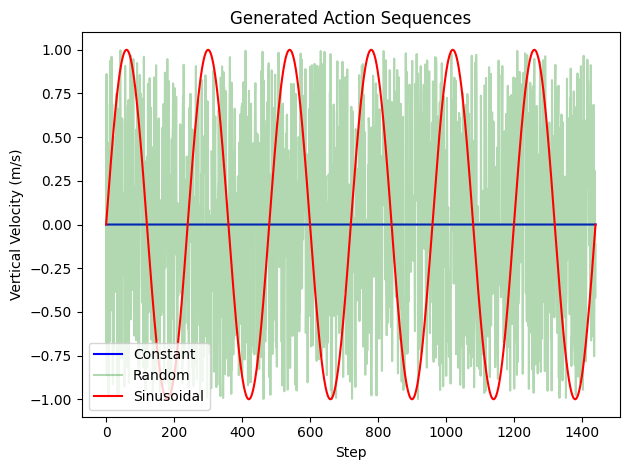

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from env.balloon_env import BalloonERAEnvironment
from env.balloon import Balloon, WindVector

# ------PARAMETERS---------
initial_lon, initial_lat = -76.5, 42.4 #deg
initial_alt = 10.0 #km
initial_volume = 1000.0  # Initial volume (m³)
initial_sand = 100  # Initial sand mass (kg)
start_time_np = ds.valid_time.values[0]
start_time = pd.to_datetime(start_time_np).to_pydatetime()
duration_seconds = 24*3600
dt_seconds = 60
n_steps = int(duration_seconds / dt_seconds)
wf = WindField(ds, start_time=start_time)
wf.disable_noise()

balloon = Balloon(
    initial_lat=initial_lat,
    initial_lon=initial_lon,
    initial_alt=initial_alt,
    initial_volume=initial_volume,
    initial_sand=initial_sand
)
initial_helium = balloon.helium_mass
init_pressure = balloon.altitude_to_pressure(initial_alt * 1000)


# Generate the action sequences
constant_actions = [0.0] * n_steps
print(f"Constant action sequence: {constant_actions}")
random_actions = np.random.uniform(-1, 1, n_steps)
print(f"Random action sequence: {random_actions}")
sin_actions = np.sin(np.linspace(0, 12*np.pi, n_steps))
print(f"Sinusoidal action sequence: {sin_actions}")

plt.plot([i for i in range(n_steps)], constant_actions, 'b-', label='Constant')
plt.plot([i for i in range(n_steps)], random_actions, 'g-', label='Random', alpha=0.3)
plt.plot([i for i in range(n_steps)], sin_actions, 'r-', label='Sinusoidal')
plt.title(f'Generated Action Sequences')
plt.xlabel('Step')
plt.ylabel('Vertical Velocity (m/s)')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [139]:
def plot_pressure(pressure_profile):
  # Plotting pressure kevel over time
  plt.plot(pressure_profile, 'b-')
  plt.grid(True)
  plt.title(f'Pressure Profile')
  plt.xlabel('Time Step')
  plt.ylabel('Pressure (hPa)')

  plt.tight_layout()
  plt.show()
  plt.savefig('balloon_altitude.png')
  plt.close()

def plot_resources(actions, velocities, helium_mass, sands):
  # Plotting the intended velocity vs actual velocity and resource usage over time
  plt.figure(figsize=(12, 4))

  # (1) Target velocity (action) vs. Current velocity
  plt.subplot(1, 2, 1)
  plt.plot(actions, label='Target velocity (action)')
  plt.plot(velocities, label='Current vertical velocity')
  plt.xlabel('Step')
  plt.ylabel('Velocity (m/s)')
  plt.title('Target vs. Current Vertical Velocity')
  plt.legend()
  plt.grid(True)

  # (2) Resource (volume, sand)
  plt.subplot(1, 2, 2)
  plt.plot(helium_mass, label='Helium Mass')
  plt.plot(sands, label='Sand')
  plt.xlabel('Step')
  plt.ylabel('Resource')
  plt.title('Resource Change')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()
  plt.savefig('balloon_velocity_and_resource.png')
  plt.close()

In [140]:
# Plots the trajectory on a map given an action list - credit to ERA5 Wind Field notebook
def get_trajectory_info(balloon, n_steps, dt_seconds, action_list, action_type:str):
    balloon.vertical_velocity = 0.0
    pressure_profile = []
    latitudes = []
    longitudes = []
    helium_masses = []
    sand_masses = []
    velocities = []

    pressure_profile.append(balloon.altitude_to_pressure(balloon.alt * 1000))
    latitudes.append(balloon.lat)
    longitudes.append(balloon.lon)
    velocities.append(balloon.vertical_velocity)
    helium_masses.append(balloon.helium_mass)
    sand_masses.append(balloon.sand)
    burst_flag = False
    depletion_flag = False

    # Run simulation
    for i in range(n_steps):
        elapsed_h = (i * dt_seconds) / 3600.0
        prev = pressure_profile[i]
        wind = wf.get_wind(balloon.lon, balloon.lat, prev, elapsed_h)
        # Control the balloon's altitude with velocity
        balloon.step(wind, dt_seconds, action_list[i])

        pressure_profile.append(balloon.altitude_to_pressure(balloon.alt * 1000))
        latitudes.append(balloon.lat)
        longitudes.append(balloon.lon)
        helium_masses.append(balloon.helium_mass)
        sand_masses.append(balloon.sand)
        velocities.append(balloon.vertical_velocity)

    fig, ax = plt.subplots(
        figsize=(12,6),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # around the North America
    ax.set_extent([-180,0,0,90], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.coastlines('50m', linewidth=0.5)

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False; gl.right_labels = False

    # 1) Plot the trajectory line in grey
    ax.plot(longitudes, latitudes,
            transform=ccrs.PlateCarree(),
            color='blue', linewidth=1)

    # 3) Start/end markers
    ax.scatter(longitudes[0], latitudes[0],
              transform=ccrs.PlateCarree(),
              color='green', marker='o', s=80,
              label='Start')
    ax.scatter(longitudes[-1], latitudes[-1],
              transform=ccrs.PlateCarree(),
              color='red', marker='X', s=80,
              label='End')

    ax.set_title("Balloon Trajectory with " + action_type + " Actions")
    ax.set_xlabel("Longitude (°E)")
    ax.set_ylabel("Latitude (°N)")
    ax.legend(loc='lower left')

    plt.show()
    return pressure_profile, velocities, helium_masses, sand_masses

Constant actions:

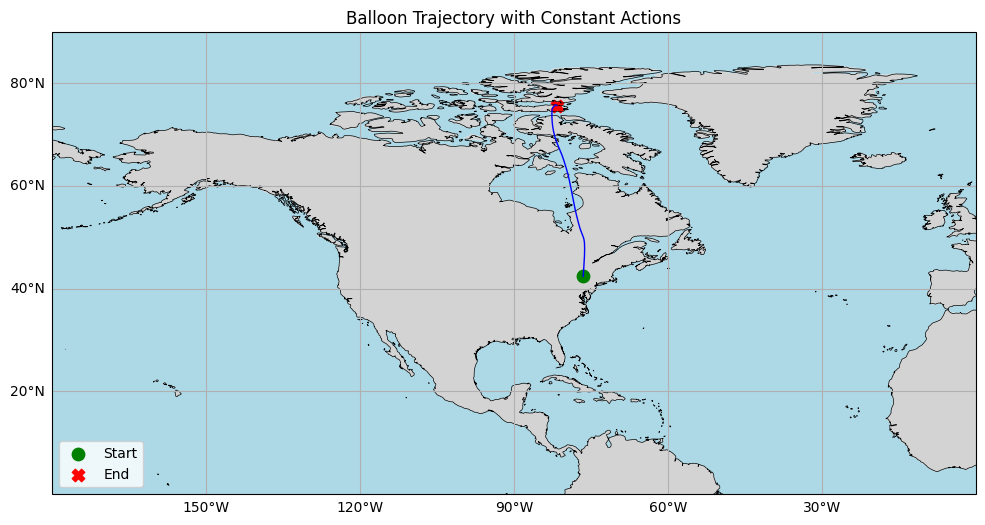

In [141]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Make sure to reset the balloon each run
balloon.reset(
    initial_lat=initial_lat,
    initial_lon=initial_lon,
    initial_alt=initial_alt,
    initial_volume=initial_volume,
    initial_sand=initial_sand
)

pressure_profile, velocities, helium_masses, sand_masses = get_trajectory_info(balloon, n_steps, dt_seconds, constant_actions, 'Constant')


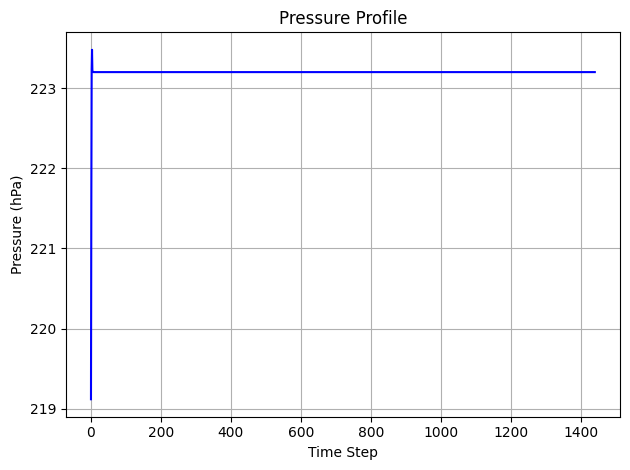

In [142]:
plot_pressure(pressure_profile)

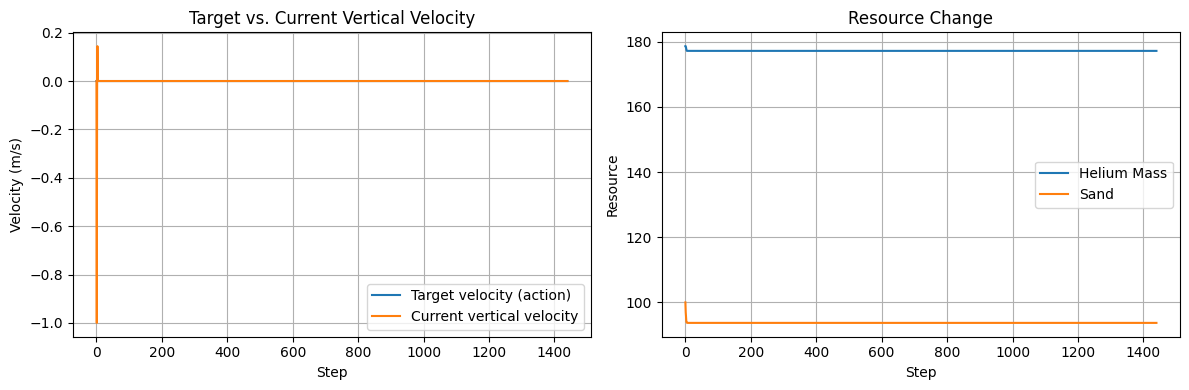

In [143]:
plot_resources(constant_actions, velocities, helium_masses, sand_masses)

Random sequence:

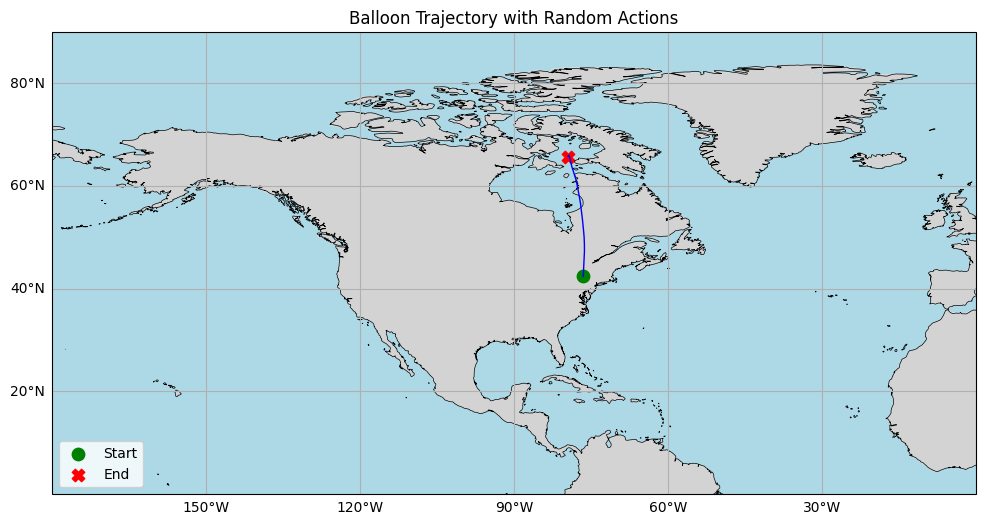

In [144]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

balloon.reset(
    initial_lat=initial_lat,
    initial_lon=initial_lon,
    initial_alt=initial_alt,
    initial_volume=initial_volume,
    initial_sand=initial_sand
)

pressure_profile, velocities, helium_masses, sand_masses = get_trajectory_info(balloon, n_steps, dt_seconds, random_actions, 'Random')


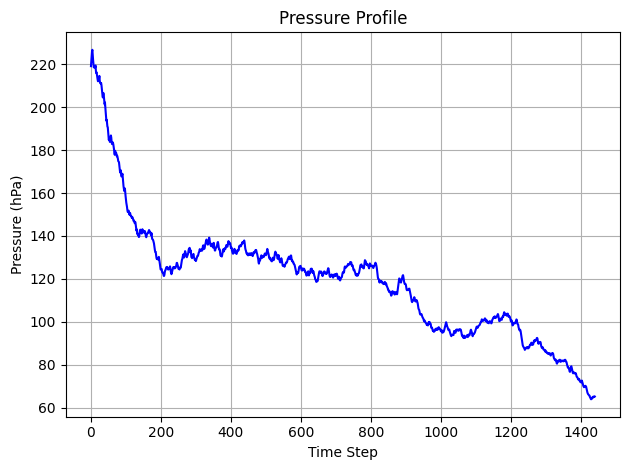

In [145]:
plot_pressure(pressure_profile)

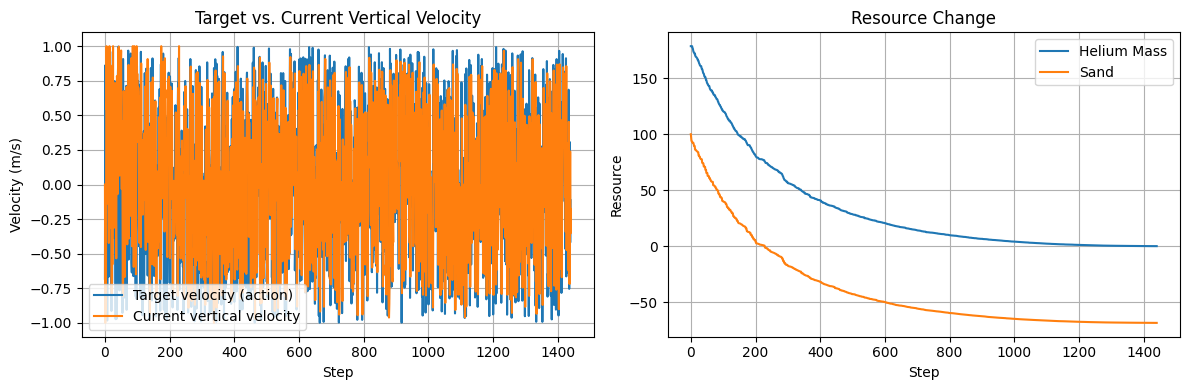

In [146]:
plot_resources(random_actions, velocities, helium_masses, sand_masses)

Sinusoidal sequence:

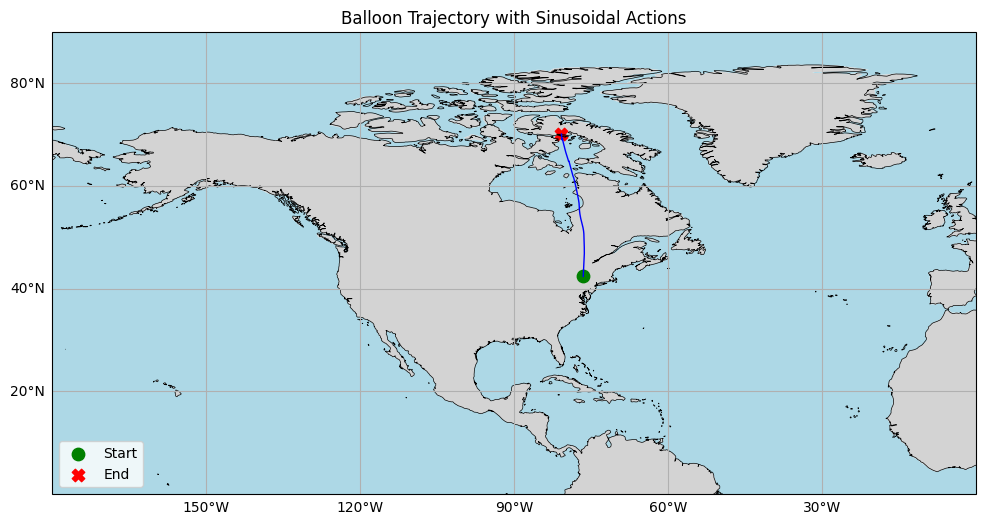

In [147]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

balloon.reset(
    initial_lat=initial_lat,
    initial_lon=initial_lon,
    initial_alt=initial_alt,
    initial_volume=initial_volume,
    initial_sand=initial_sand
)

pressure_profile, velocities, helium_masses, sand_masses = get_trajectory_info(balloon, n_steps, dt_seconds, sin_actions, 'Sinusoidal')


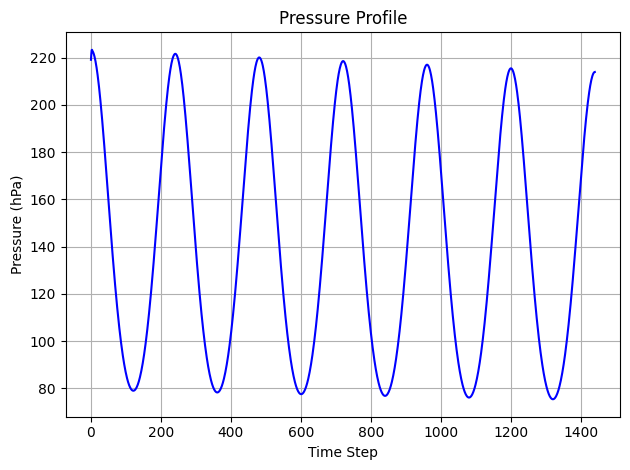

In [148]:
plot_pressure(pressure_profile)

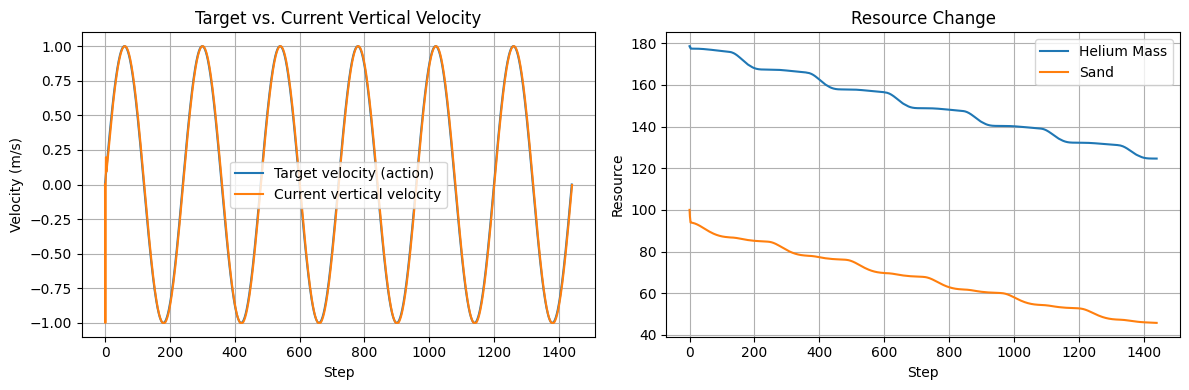

In [149]:
plot_resources(sin_actions, velocities, helium_masses, sand_masses)